<a href="https://colab.research.google.com/github/araujoheloysa/DIO_BairesDev_Machine-Learning-Practitioner/blob/main/M%C3%A9tricas_de_avalia%C3%A7%C3%A3o_de_aprendizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Importing libraries**

In [1]:
import tensorflow as tf
import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
import os
import zipfile
import matplotlib.image as mpimg
import random

# **2. Dataset cats and dogs**

In [2]:
# Dataset URL
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"

# Download the dataset
data_cats_dogs_zip = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=dataset_url, extract=False)

# Extract the zip file manually
with zipfile.ZipFile(data_cats_dogs_zip, 'r') as zip_ref:
    zip_ref.extractall(os.path.dirname(data_cats_dogs_zip)) # Extract to the same directory as the zip file

# Define the path to the extracted dataset
data_cats_dogs = os.path.join(os.path.dirname(data_cats_dogs_zip), 'cats_and_dogs_filtered') # Path to the extracted 'PetImages' folder

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# **3. Separate the dataset into train and validation**

In [3]:
# 70% dataset for training
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_cats_dogs,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(160, 160),
  batch_size=32)

# 30% dataset for validation
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_cats_dogs,
  validation_split=0.30,
  subset="validation",
  seed=123,
  image_size=(160,160),
  batch_size=32)


Found 3000 files belonging to 2 classes.
Using 2100 files for training.
Found 3000 files belonging to 2 classes.
Using 900 files for validation.


# **4. Loading the Pre-trained Model**

In [4]:
# Loads the pre-trained MobileNet model, excluding the last two layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# Adds a global pooling layer to reduce dimensionality
x = GlobalAveragePooling2D()(base_model.output)

# Adds intermediate layer with L2 regularization
x = Dense(50, activation='relu', kernel_regularizer=l2(0.01))(x)

# Output layer
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [6]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_data_dir = os.path.join(data_cats_dogs, 'train')
validation_data_dir = os.path.join(data_cats_dogs, 'validation')

# Creating Data Generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(160, 160),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,  # Use the correct path
    target_size=(160, 160),
    batch_size=32,
    class_mode='binary'
)

# Callbacks used during training to improve the model and prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
# Frozen layers to train the model
history = model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[early_stopping, reduce_lr])

# Unfreezes the base model layers
for layer in base_model.layers:
    layer.trainable = True

# Compile again at a lower learning rate
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Fine-Tuning
history_finetune = model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[early_stopping, reduce_lr])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.8304 - loss: 1.1692 - val_accuracy: 0.9630 - val_loss: 0.6340 - learning_rate: 0.0010
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9448 - loss: 0.6054 - val_accuracy: 0.9780 - val_loss: 0.3961 - learning_rate: 0.0010
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9575 - loss: 0.4079 - val_accuracy: 0.9770 - val_loss: 0.2849 - learning_rate: 0.0010
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9567 - loss: 0.3201 - val_accuracy: 0.9760 - val_loss: 0.2234 - learning_rate: 0.0010
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9720 - loss: 0.2331 - val_accuracy: 0.9760 - val_loss: 0.1872 - learning_rate: 0.0010
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9632 - loss: 0.2123 - val_accuracy: 0.9740 - val_loss: 0.1653 - learning_rate: 0.0010
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.9617 - loss: 0.1905 - val_accuracy: 

In [9]:
# Evaluation after fine-tuning
val_loss, val_accuracy = model.evaluate(validation_generator)

print(f"Validation model accuracy after fine-tuning: {val_accuracy * 100:.2f}%")
print(f"Loss model after fine-tuning: {val_loss:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 742ms/step - accuracy: 0.9597 - loss: 0.1033
Validation model accuracy after fine-tuning: 96.30%
Loss model after fine-tuning: 0.1091


# **5. Obtain the model's predictions on the validation set**

In [11]:
#Reset the validation generator to avoid order problems
validation_generator.reset()

y_pred_probs = model.predict(validation_generator)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = validation_generator.classes

32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 691ms/step


# **6. Calculate confusion matrix**

In [27]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

VP_dogs = cm[1, 1]  # True Positives (dogs predicted as dogs)
VN_cats = cm[0, 0]  # True Negatives (Cats predicted as Cats)
FP_cats = cm[0, 1]  # False Positives (Cats predicted as Dogs)
FN_dogs = cm[1, 0]  # False Negatives (Dogs predicted as Cats)

print(f"True Positive (TP) - Dogs: {VP_dogs}")
print(f"True Negative (TN) - Cats: {VN_cats}")
print(f"False Positive (FP) - Cats: {FP_cats}")
print(f"False Negative (FN) - Dogs: {FN_dogs}")

True Positive (TP) - Dogs: 237
True Negative (TN) - Cats: 234
False Positive (FP) - Cats: 266
False Negative (FN) - Dogs: 263


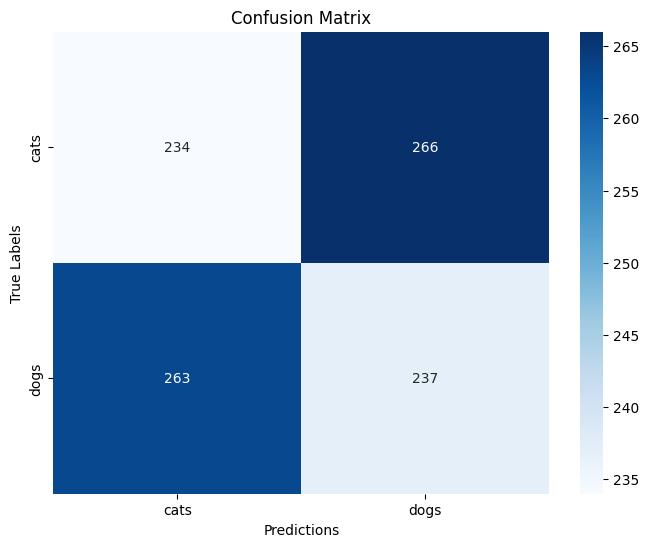

In [28]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['cats', 'dogs'],
            yticklabels=['cats', 'dogs'])
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **7. Calculate the metrics**

In [31]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

# Extract the values
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

# Calculate metrics
acuracy = (TP + TN) / (TP + TN + FP + FN)
Recall = TP / (TP + FN)
Specificity = TN / (TN + FP)
Precision = TP / (TP + FP)
f_score = 2 * (Precision * Recall) / (Precision + Recall)

# Print results
print(f"Accuracy: {acuracy:.4f}")
print(f"Recall: {Recall:.4f}")
print(f"Specificity: {Specificity:.4f}")
print(f"Precision: {Precision:.4f}")
print(f"F-score: {f_score:.4f}")

Accuracy: 0.4710
Recall: 0.4740
Specificity: 0.4680
Precision: 0.4712
F-score: 0.4726


In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['cats', 'dogs']))

              precision    recall  f1-score   support

        cats       0.47      0.47      0.47       500
        dogs       0.47      0.47      0.47       500

    accuracy                           0.47      1000
   macro avg       0.47      0.47      0.47      1000
weighted avg       0.47      0.47      0.47      1000



# **8. Conclusions**

Based on the metrics provided, we can conclude that the neural network in question has a sub-optimal classification performance. All the metrics (accuracy, recall, specificity, precision and F-score) are around 0.47, indicating that the model gets approximately 47% of the predictions right.

In detail:

**Accuracy: 0.4710 (47.10%)** - indicates that the model correctly classifies just under half of the samples.

**Recall: 0.4740 (47.40%)** - shows that the model correctly identifies 47.40% of real positive cases (e.g. animals that really are dogs).

**Specificity: 0.4680 (46.80%)** - shows that the model correctly identifies 46.80% of real negative cases (e.g. animals that really are cats).

**Precision: 0.4712 (47.12%)** - means that when the model classifies an animal as a dog, it gets it right 47.12% of the time.

**F-score: 0.4726 (47.26%)** - represents the harmonic mean between precision and recall, indicating a poor balance between the two metrics.

The neural network shows difficulties in distinguishing the classes, with performance close to that of a random classifier. This suggests that the model may not have learned the characteristic patterns of the classes or that the training data is not sufficient or of adequate quality.